# Training Models on Large Datasets on Palmetto Cluster using Dask

This notebook is based on the Dask examples available at <https://examples.dask.org/>. See there
for other machine learning and data analysis worfklows using Dask.

## 0. Before you begin

This Notebook is meant to be run on Palmetto Cluster's [JupyterHub](https://www.palmetto.clemson.edu/jupyterhub/).
Before running this notebook, you shoud start a Dask cluster on Palmetto by following the instructions [here](https://www.palmetto.clemson.edu/palmetto/workflows_dask.html).

After starting the Dask cluster, you can "connect" to it from this Notebook with the following code:

In [3]:
import getpass
username = getpass.getuser()

from dask.distributed import Client
client = Client(scheduler_file='/home/{}/dask-scheduler.json'.format(username))
client

Client Scheduler: tcp://10.128.1.232:8088 Dashboard: http://10.128.1.232:8787/status,Cluster Workers: 4 Cores: 80 Memory: 539.54 GB


## 1. Introduction

In this notebook,
we'll demonstrate the use of [Dask-ML](https://dask-ml.readthedocs.io/en/latest/) for
performing K-means clustering of a sizeable dataset.

We'll run [`scikit-learn`](https://scikit-learn.org/stable/) k-means on a single node,
and compare the runtime with
[Dask-ML](https://dask-ml.readthedocs.io/en/latest/) k-means
using 4 nodes (a total of 64 cores).

## 2. Training on a single node (scikit-learn)

### 2.1 Generating the dataset

We use the `make_blobs` function below to create a dataset of 100000000 points that we'll cluster with KMeans.

In [4]:
import sklearn
import sklearn.datasets
import sklearn.cluster

N = 100000000
X, y = sklearn.datasets.make_blobs(n_samples=N, random_state=0, centers=3)

### 2.2 Clustering

Next, we use `scikit-learn`'s k-means algorithm to cluster the points. Note that this version of k-means can only run on a single node, and the dataset must fit in the RAM of that node.

In [5]:
km = sklearn.cluster.KMeans(n_clusters=3, n_init=1)

In [6]:
import time
t1 = time.time()
km.fit(X, y)
t2 = time.time()
print("Clustering took {} seconds.".format(t2-t1))

Clustering took 82.17207098007202 seconds.


### 2.3 Inspecting results

Below, we visualize the results of the clustering,
and check the locations of the centroids:

In [7]:
%matplotlib inline

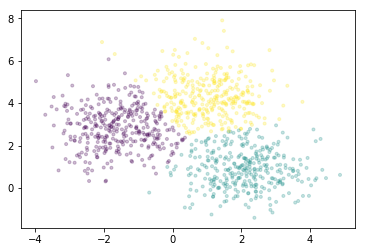

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(X[::100000, 0], X[::100000, 1], marker='.', c=km.labels_[::100000],
           cmap='viridis', alpha=0.25);

In [9]:
km.cluster_centers_

array([[-1.59888541,  2.88738218],
       [ 2.06672586,  0.87201603],
       [ 1.02312392,  4.37001145]])

## 3. Distributed training (Dask-ML)

In [10]:
import dask_ml.datasets
import dask_ml.cluster
import dask.array as da

### 3.2 Converting dataset to Dask Arrays

Below, we convert the NumPy arrays `X` and `y` into *Dask arrays* using the `da.from_array()` function.
Performance can be dependent on the *chunk_size* parameter - see [here](http://docs.dask.org/en/latest/array-chunks.html) for more information.
Here we choose a chunk size of a few MB.

In [11]:
chunk_size = 2000000
X, y = da.from_array(X, chunks=(chunk_size,-1)), da.from_array(y, chunks=(chunk_size,))

#X, y = dask_ml.datasets.make_blobs(n_samples=100000000,
#                                    chunks=chunk_size,
#                                    random_state=0,
#                                    centers=3)

X = X.persist()
y = y.persist()

Sine the above commands run in the background, you will need to wait a few seconds for the Dask arrays `X` and `y` are loaded into memory.

### 3.3 Clustering

We use the Dask-ML version of
[KMeans](https://dask-ml.readthedocs.io/en/latest/modules/generated/dask_ml.cluster.KMeans.html)
which can work with Dask arrays.

The dataset is distributed among the nodes of the Dask cluster,
so it doesn't need to fit in the RAM of a single node.
The computations are parallelized on all cores of the Dask cluster,
so we expect to see a speedup over `scikit-learn`'s k-means.

In [12]:
km = dask_ml.cluster.KMeans(n_clusters=3, init_max_iter=1, oversampling_factor=10)

In [13]:
import time
t1 = time.time()
result = km.fit(X, y)
t2 = time.time()
print("Clustering took {} seconds.".format(t2-t1))

Clustering took 15.410752773284912 seconds.


### 3.4 Inspecting results

We can compare the results with those previously obtained:

In [14]:
%matplotlib inline

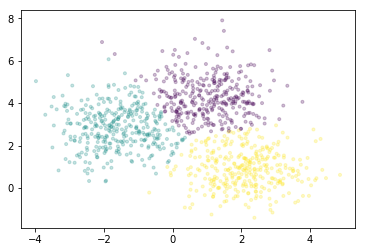

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(X[::100000, 0], X[::100000, 1], marker='.', c=km.labels_[::100000],
           cmap='viridis', alpha=0.25);

In [16]:
km.cluster_centers_

array([[ 1.02117721,  4.3756876 ],
       [-1.597161  ,  2.88581265],
       [ 2.06642445,  0.87603107]])